In [1]:
import numpy as np

from scipy.stats import gamma, expon
from scipy.special import gamma as gammafunc

import matplotlib.pyplot as plt
from corner import corner

from emcee.autocorr import integrated_time

# Toy Problem: target distribution

Consider the 2-dimensional target distribution with PDF

$$  P(x,y) \propto y\exp(-[xy+y]) , $$

with $0<x,y<\infty$.

In [2]:
def target_logPDF(x, y):
    return np.log(y) - (x*y+y)

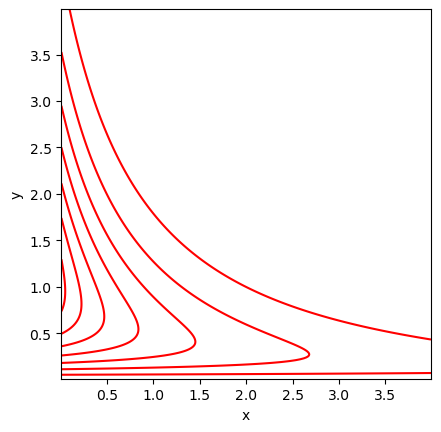

In [3]:
fig, ax = plt.subplots()
ax.set_box_aspect(1)

pts = np.arange(0, 4.0, 0.01)[1:]
X, Y = np.meshgrid(pts, pts)
Z = np.exp(target_logPDF(X, Y))
ax.contour(X, Y, Z, colors='r')

ax.set_xlabel('x')
ax.set_ylabel('y')

plt.show()

# 1D Conditional Distributions

$$ x|y \sim \mathrm{Exp}(y) $$

$$ y|x \sim \mathrm{Gamma}(2, \frac{1}{x+1}) $$

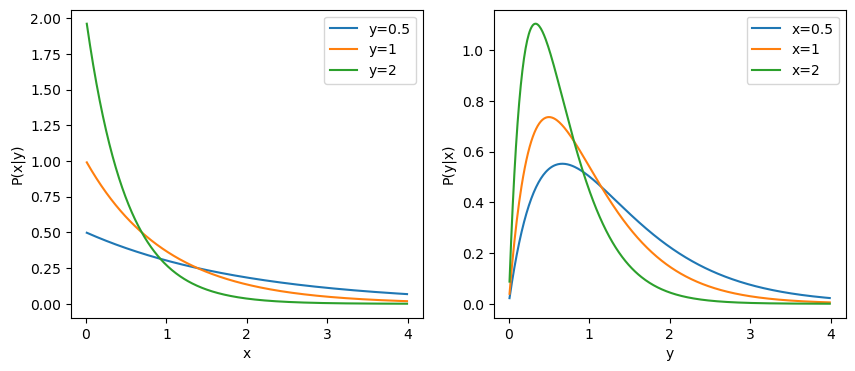

In [4]:
fig, [ax0, ax1] = plt.subplots(ncols=2, figsize=(10,4))

x = np.arange(0, 4.0, 0.01)[1:]
y_vals = [0.5, 1, 2]
for y in y_vals:
    ax0.plot(x, expon(scale=1/y).pdf(x), label='y={}'.format(y))
ax0.set_xlabel('x')
ax0.set_ylabel('P(x|y)')
ax0.legend()

y = np.arange(0, 4.0, 0.01)[1:]
x_vals = [0.5, 1, 2]
for x in x_vals:
    ax1.plot(y, gamma(2, scale=1/(x+1)).pdf(y), label='x={}'.format(x))
ax1.set_xlabel('y')
ax1.set_ylabel('P(y|x)')
ax1.legend()

plt.show()

# Sampling

In [5]:
num_iter = 100000
chain = np.zeros((num_iter, 2))

chain[0] = np.array([+1,+1])                          # initialise
for i in range(num_iter-1):                           # sampling loop
    x_current, y_current = chain[i]                   # current position
    idx = np.random.choice([0,1])                     # index to update (equal weights)
    if idx==0:
        x_new = expon(scale=1/y_current).rvs()        # x|y ~ Exp(y)  
        y_new = y_current                             # y doesn't change
    elif idx==1:
        x_new = x_current                             # x doesn't change
        y_new = gamma(2, scale=1/(x_current+1)).rvs() # y|x ~ Gamma(2, 1/(x+1))
    else:
        pass
    chain[i+1] = np.array([x_new, y_new])             # store new position in chain

# Examine the chain

The Gibbs algorithm moves at every iteration (i.e. the acceptance fraction is 1) but only one coordinate changes at each move.

In [6]:
for i in range(5):
    print(chain[i])

[1. 1.]
[1.         1.13813134]
[0.49057189 1.13813134]
[0.320043   1.13813134]
[0.767575   1.13813134]


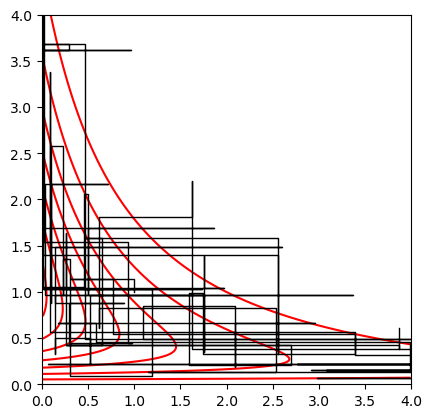

In [7]:
fig, ax = plt.subplots()
ax.set_box_aspect(1)

pts = np.arange(0, 4.0, 0.01)[1:]
X, Y = np.meshgrid(pts, pts)
Z = np.exp(target_logPDF(X, Y))
ax.contour(X, Y, Z, colors='r')

first_n_steps = 200
ax.plot(chain[0:first_n_steps,0], chain[0:first_n_steps,1], color='k', lw=1)

lim = (0, 4)
ax.set_xlim(*lim)
ax.set_ylim(*lim)

plt.show()

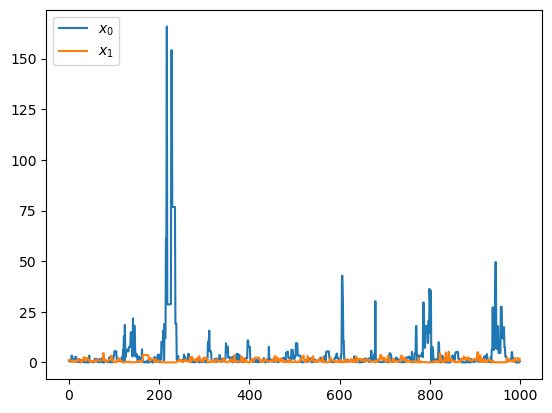

Correlation length estimate: (array([13.36857038]), array([8.6861959]))


In [8]:
fig, ax = plt.subplots()

first_n_steps = 1000

ax.plot(chain[0:first_n_steps,0], label=r'$x_0$')
ax.plot(chain[0:first_n_steps,1], label=r'$x_1$')

plt.legend(loc='upper left')
plt.show()

tau = integrated_time(chain[:,0]), integrated_time(chain[:,1])
print(f"Correlation length estimate: {tau}")

In [9]:
burnin = 0
thin = 2*int(np.max(tau))
samples = chain[burnin::thin,:]

print(f"Number of i.i.d. samples produced = {len(samples)}")

Number of i.i.d. samples produced = 3847


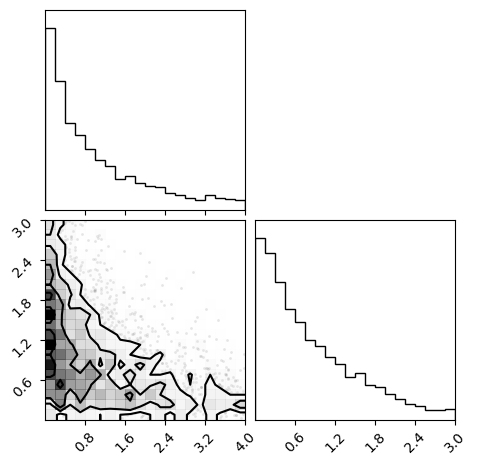

In [10]:
corner(samples, range=[[0,4], [0,3]])
plt.show()